<a href="https://colab.research.google.com/github/sharathchandran2001/MaveSeleniumGridReportEmail/blob/master/0_1_qml_quantum_drift.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

 Quantum Drift Detection Using PennyLane

In [1]:
# --- Install Dependencies (uncomment if needed) ---
!pip install pennylane scikit-learn matplotlib numpy

/usr/local/lib/python3.11/dist-packages/pennylane/capture/capture_operators.py:33: RuntimeWarning: PennyLane is not yet compatible with JAX versions > 0.4.28. You have version 0.5.2 installed. Please downgrade JAX to <=0.4.28 to avoid runtime errors.
  warnings.warn(


Quantum Drift Detection Threshold (95th percentile entropy): 1.2180


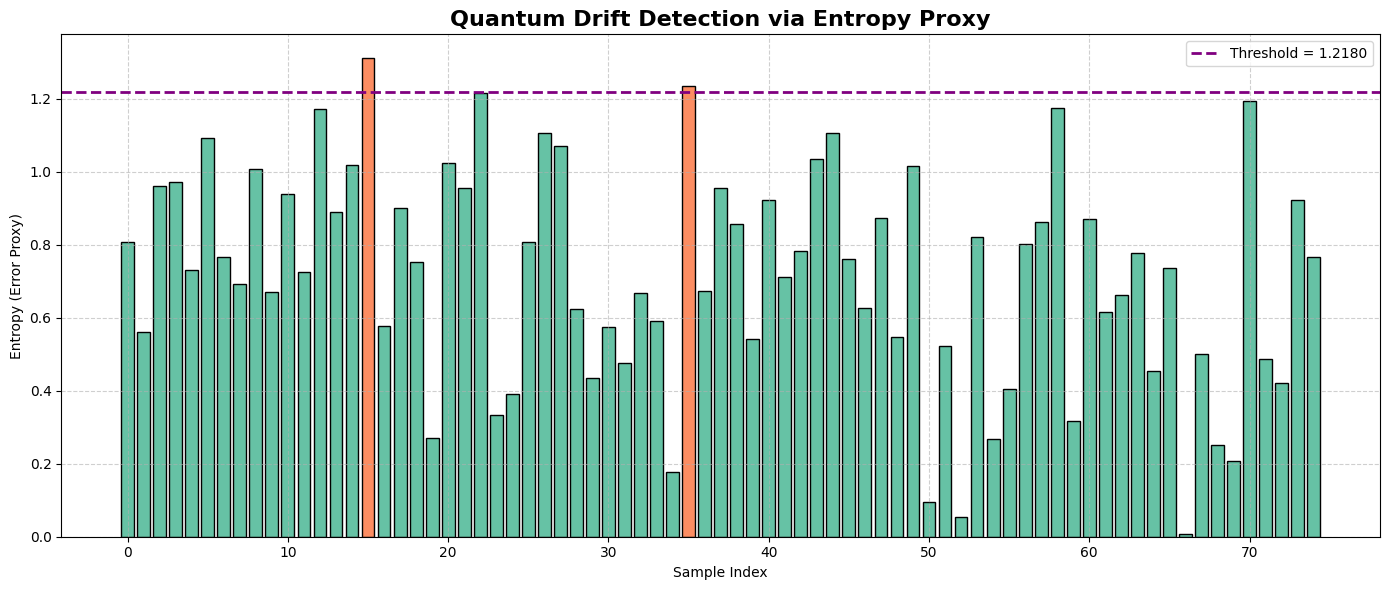

In [2]:
# --- Install Dependencies (uncomment if needed) ---
# !pip install pennylane scikit-learn matplotlib numpy

# --- Imports ---
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error
import pennylane as qml

# === 1. Load Iris Dataset and Simulate Drift ===
X = load_iris().data
X_train, X_test = train_test_split(X, test_size=0.5, random_state=42)

# Inject synthetic drift into first 25 test records
X_test[:25, 0] += 2

# === 2. Scale Data ===
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# === 3. Apply PCA to Reduce to 2D for 2 Qubits ===
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

# === 4. Quantum Circuit Setup ===
dev = qml.device("default.qubit", wires=2, shots=1000)

@qml.qnode(dev)
def quantum_autoencoder(x):
    """Encodes a 2D sample into RX gates and returns measurement probs."""
    for i in range(2):
        qml.RX(x[i], wires=i)
    return qml.probs(wires=[0, 1])

def reconstruction_error(probs):
    """Entropy as a proxy for uncertainty / reconstruction error."""
    return -np.sum([p * np.log(p + 1e-10) for p in probs])

# === 5. Calculate Training Entropies ===
train_errors = np.array([reconstruction_error(quantum_autoencoder(x)) for x in X_train_pca])
threshold = np.percentile(train_errors, 95)
print(f"Quantum Drift Detection Threshold (95th percentile entropy): {threshold:.4f}")

# === 6. Test Samples: Calculate Errors & Detect Drift ===
test_errors = []
drift_flags = []

for x in X_test_pca:
    probs = quantum_autoencoder(x)
    err = reconstruction_error(probs)
    test_errors.append(err)
    drift_flags.append(err > threshold)

# === 7. Visualization ===
plt.figure(figsize=(14, 6))
colors = ['#66c2a5' if not flag else '#fc8d62' for flag in drift_flags]
plt.bar(range(len(test_errors)), test_errors, color=colors, edgecolor='black')
plt.axhline(y=threshold, color='purple', linestyle='--', linewidth=2, label=f"Threshold = {threshold:.4f}")
plt.title("Quantum Drift Detection via Entropy Proxy", fontsize=16, weight='bold')
plt.xlabel("Sample Index")
plt.ylabel("Entropy (Error Proxy)")
plt.legend(loc='upper right')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()
